In [1]:
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from collections import Counter
from nltk.tokenize import wordpunct_tokenize
import re
from string import punctuation

In [2]:
attend = pd.read_csv('../data/attend.csv')
groups = pd.read_csv('../data/groups.csv')
test = pd.read_csv('../data/test.csv')
users = pd.read_csv('../data/users.csv')

dct = pd.read_excel('../data/dict.xlsx')

In [3]:
attend.head()

,уникальный номер занятия,уникальный номер группы,уникальный номер участника,направление 2,направление 3,онлайн/офлайн,дата занятия,время начала занятия,время окончания занятия
0,401346550,801346550,101352023,ОНЛАЙН Гимнастика,ОНЛАЙН Цигун,Да,2022-08-01,09:00:00,10:00:00
1,401346550,801346550,101385462,ОНЛАЙН Гимнастика,ОНЛАЙН Цигун,Да,2022-08-01,09:00:00,10:00:00
2,401346550,801346550,101421897,ОНЛАЙН Гимнастика,ОНЛАЙН Цигун,Да,2022-08-01,09:00:00,10:00:00
3,401346550,801346550,101354499,ОНЛАЙН Гимнастика,ОНЛАЙН Цигун,Да,2022-08-01,09:00:00,10:00:00
4,401346550,801346550,101421312,ОНЛАЙН Гимнастика,ОНЛАЙН Цигун,Да,2022-08-01,09:00:00,10:00:00


<AxesSubplot:>

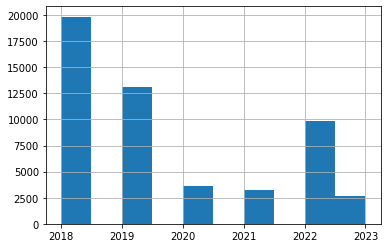

In [4]:
users['дата создание личного дела'].apply(lambda x: x[:4]).astype(int).hist()

<AxesSubplot:>

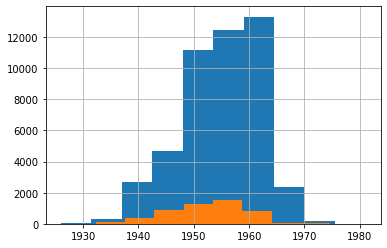

In [5]:
users[users['пол'] == 'Женщина']['дата рождения'].apply(lambda x: x[:4]).astype(int).hist()
users[users['пол'] == 'Мужчина']['дата рождения'].apply(lambda x: x[:4]).astype(int).hist()

## Преобразование данных


### Юзеры

In [6]:
postal_codes = pd.read_csv('postal_codes.csv')

atypes = {
    'парк', 'улица', 'пл', 'ул', 'шоссе', 'км', 'пр', 'кт', 'мжд'
}

postal_codes['splitted'] = postal_codes['street'].apply(
    lambda x: tuple(
        sorted(
            i.lower().replace('ё', 'е') 
            for i in wordpunct_tokenize(x) 
            if len(i) > 1 and i[0] not in '0123456789' and i.lower() not in atypes
        )
    )
)

grouped = postal_codes.groupby(['splitted', 'postal_code']).agg(lambda x: list(x)[0])

postal_codes = grouped.reset_index()


to_skip = {
    'авиаконструктора', 'адмирала', 'академика', 'архитектора', 'братьев', 'ветеранов', 'генерала',
    'героев', 'защитников', 'космонавта', 'летчика', 'маршала', 
    'воскресенско', 'москва', 'мжд'
}

names = {
    'александра', 'алексея', 'бориса', 'василия', 'дмитрия', 'ивана', 'константина',
     'льва', 'марии', 'михаила', 'наташи', 'николая', 'павла', 'петра', 'сергея', 'степана', 'федора',
}

postal_codes['head'] = [
    None if len(j) == 0 else j[0]
    for j in 
    [
        [i for i in splitted if len(i) >= 4 and i not in to_skip and i not in names and i not in atypes]
        if splitted and max(len(i) for i in splitted) > 3
        else []
        for code, splitted in postal_codes[['postal_code', 'splitted']].values
    ]
]

grouped = postal_codes.groupby('head').agg(list)
grouped = grouped[grouped['postal_code'].apply(lambda x: len(set(x))) > 1]
not_ok = set(grouped.index)

In [7]:
postal_codes[postal_codes['head'] == 'даниловский']

,splitted,postal_code,street,head
510,"(вал, даниловский)",115093,Даниловский Вал ул.,даниловский
859,"(даниловский, пер)",115191,Даниловский пер.,даниловский


In [8]:
simple_dict = {
    head: (code, splitted)
    for code, splitted, head in postal_codes[['postal_code', 'splitted', 'head']].values
    if splitted and head not in not_ok
}

simple_dict['ленинский']

(117198, ('ленинский',))

In [9]:
users['code'] = users['адрес проживания'].apply(wordpunct_tokenize).apply(
    lambda x: [
        simple_dict[i.lower().strip().replace('ё', 'е')]  
        for i in x
        if len(x) > 1 and i.lower().strip().replace('ё', 'е') in simple_dict
    ]
    if type(x) == list else []
)

In [10]:
users['code'] = users['адрес проживания'].apply(wordpunct_tokenize).apply(
    lambda x: [
        simple_dict[i.lower().strip().replace('ё', 'е')]  
        for i in x
        if len(x) > 1 and i.lower().strip().replace('ё', 'е') in simple_dict
    ]
    if type(x) == list else []
).apply(lambda x: x[0][0] if len(x) > 0 else None)

In [11]:
manual = {
    'варшавское шоссе': 115127, 
    'ярославское шоссе': 129626,
    'ореховый бульвар': 115551,
    'боровское шоссе': 108810,
    'проспект мира': 127083, 
    'бескудниковский бульвар': 127247, 
    'кутузовский проспект': 121108, 
    'измайловский бульвар': 105043
}

In [12]:
users['code'].isnull().mean()

0.17543088623074865

In [13]:
users['code'] = users[['code', 'адрес проживания']].apply(
    lambda x: manual[x['адрес проживания'].split(',')[1].strip()] 
            if str(x['code']) != 'NaN' and x['адрес проживания'].split(',')[1].strip() in manual 
            else x['code']
    , axis=1
)

users['code'].isnull().mean()

0.1529598349065617

In [14]:
users_new = pd.DataFrame({
    'user_id': users['уникальный номер'],
    'created_at': pd.to_datetime(users['дата создание личного дела']),
    'is_woman': (users['пол'] == 'Женщина').astype(int),
    'date_of_birth': pd.to_datetime(users['дата рождения']),
    'postal_code': users['code'].fillna(0).astype(int)
})

In [15]:
users_new.to_csv('../data/new_users.csv', index=None)

### Посещения

In [16]:
attend_new = pd.DataFrame({
    'event_id': attend['уникальный номер занятия'],
    'group_id': attend['уникальный номер группы'],
    'user_id': attend['уникальный номер участника'],
    'event_date': attend['дата занятия'],
    'event_start': attend['время начала занятия'].apply(lambda x: int(x[:2]) + int(x[3:5]) / 60),
    'event_end': attend['время окончания занятия'].apply(lambda x: int(x[:2]) + int(x[3:5]) / 60),
    'is_online': (attend['онлайн/офлайн'] == 'Да').astype(int)
})

In [17]:
attend_new.to_csv('new_attend.csv', index=None)

In [18]:
attend_new['is_online'].mean()

0.6467974542446259

<AxesSubplot:>

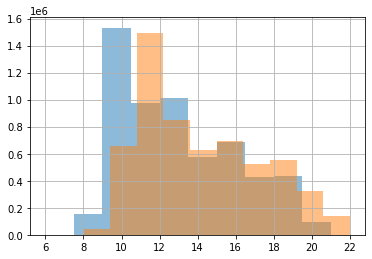

In [19]:
attend_new['event_start'].hist(alpha=0.5)
attend_new['event_end'].hist(alpha=0.5)

### Группы

In [20]:
# доля тех, где несколько площадок
groups['округ площадки'].apply(lambda x: ',' in x if type(x) == str else None).mean()

0.1125928500065158

**Расписание**

In [22]:
reg_dates = '([0-9]{2}\.[0-9]{2}\.[0-9]{4})'
reg_time = '[0-9]{2}:[0-9]{2}-[0-9]{2}:[0-9]{2}'

DAYS = {'Пн': 1, 'Вт': 2, 'Ср':3 , 'Чт': 4, 'Пт': 5, 'Сб': 6, 'Вс': 7}

def parse_date_string(x):
    if len(re.findall(reg_dates, x)) > 2:
        return [
            parse_date_string(y)[0]
            for y in x.split(';')
        ]
    
    start, finish = tuple(re.findall(reg_dates, x))
    start = start[6:] + '-' + start[3:5] + '-' + start[:2]
    finish = finish[6:] + '-' + finish[3:5] + '-' + finish[:2]
    
    x = x.split(finish)[-1].strip()
    
    timetable = []
    days = []
    for item in x.split():
        item = item.strip(punctuation)
        if item in {'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'}:
            days.append(item)
        elif re.match(reg_time, item):
            timetable.extend([(DAYS[day], int(item[:2]) + int(item[3:5]) / 60, int(item[6:8]) + int(item[9:11]) / 60) for day in days])
            days = []
    
    return [(start, finish, timetable)]

# parse_date_string(times.loc[4514])

In [23]:
groups['timetable_closed'] = groups['расписание в закрытых периодах'].apply(lambda x: parse_date_string(x) if type(x) == str else [])
groups['timetable_open'] = groups['расписание в активных периодах'].apply(lambda x: parse_date_string(x) if type(x) == str else [])
groups['timetable_plan'] = groups['расписание в плановом периоде'].apply(lambda x: parse_date_string(x) if type(x) == str else [])

**Места**

In [24]:
s_types = {
    'улица', 'шоссе', 'переулок', 'проспект', 'проезд', 
    'бульвар', 'переулок', 'набережная', 'парк',
    'тупик', 'ул', 'аллея', 'линия', 'просек'
#     , 'площадь'
}

In [25]:
def split_locations(x):
    address = x['адрес площадки']
    district = x['округ площадки']
    zone = x['район площадки']
    
    if 'онлайн' in x['направление 3'].lower():
        return -1, address, district, zone, []
    elif type(district) == float:
        return -3, address, district, zone, []
    
    if ',' in district:
        status = 2
        district = [i.strip() for i in district.split(',')]
        zone = [i.strip() for i in zone.split(',')]
    else:
        status = 1
        district = [district]
        zone = [zone]
    
    address_new = []
    city = None
    for item in address.split(','):
        item = item.lower().strip().replace('.', '')
#         print(item)
        if len(set([i for i in item.split()]) & s_types) > 0 and city is not None:
#             print('YES', item)
            address_new.append((city, item.strip()))
            city = None
            continue
        elif 'моск' in item:
            city = 'москва'
            continue
        elif 'город' in item or 'г.' in item or 'посел' in item or 'край' in item or 'республика' in item:
            city = item.strip()
            continue
            
    if status == 1:
        address_new = address_new[:1]
        
#         else:
#             print('NO', item)
#     print(len(district), len(zone), len(address_new))
    return status, address, district, zone, address_new

In [26]:
groups['location'] = groups[['направление 3', 'адрес площадки', 'округ площадки', 'район площадки']].apply(split_locations, axis=1)

In [27]:
groups['location'].apply(lambda x: x[0]).value_counts() / groups.shape[0]

 1    0.649632
-1    0.277636
 2    0.068326
-3    0.004407
Name: location, dtype: float64

In [28]:
groups['is_online'] = groups['location'].apply(lambda x: x[0] == -1).astype(int)
groups['is_mobile'] = groups['location'].apply(lambda x: x[0] == -3).astype(int)

In [29]:
groups['loc_type'] = groups['location'].apply(lambda x: x[0])
groups['match_loc'] = groups['location'].apply(lambda x: len(x[2]) == len(x[4]) if type(x[2]) == list and type(x[4]) == list else -1).astype(float)

In [30]:
groups.groupby(['loc_type', 'is_online', 'is_mobile', 'match_loc']).agg({'is_online': 'count'})

is_online
loc_type is_online is_mobile match_loc           
-3       0         1         -1.0             119
-1       1         0         -1.0            7497
 1       0         0          0.0             575
                              1.0           16967
 2       0         0          0.0             137
                              1.0            1708

In [31]:
def location_code(x):
    if x[0] < 0:
        return None
    result = []
    if type(x[2]) == list and type(x[4]) == list and len(x[2]) == len(x[4]):
        for c, loc in x[4]:
            loc = loc.lower().strip().replace('ё', 'е')
            loc_match = [i for i in loc.split() if i in simple_dict]
            if loc_match:
                result.append(simple_dict[loc_match[0]][0])
            elif loc in manual:
                result.append(manual[loc])
            else:
                result.append(None)
    return result

In [32]:
groups['codes'] = groups['location'].apply(location_code)
groups['districts'] = groups['location'].apply(lambda x: x[2])
groups['zones'] = groups['location'].apply(lambda x: x[3])

In [34]:
cat1_dict = dict(dct[['level1', 'id_level1']].values)
cat2_dict = dict(dct[['level2', 'id_level2']].values)
cat3_dict = dict(dct[['leve3', 'id_level3']].values)

In [35]:
groups['is_available'] = (~groups['расписание в активных периодах'].isnull()).astype(int)

In [36]:
groups_new = pd.DataFrame({
    'group_id': groups['уникальный номер'],
    'address': groups['адрес площадки'],
    'category1_id': groups['направление 1'].apply(cat1_dict.get),
    'category2_id': groups['направление 2'].apply(cat2_dict.get),
    'category3_id': groups['направление 3'].apply(cat3_dict.get),
    'is_online': groups['is_online'],
    'is_mobile': groups['is_mobile'],
    'is_available': groups['is_available'],
    'match_loc': (groups['match_loc'] != 0).astype(int),
})

In [37]:
groups_new.to_csv('new_groups.csv', index=None)

In [39]:
district_cnt = Counter()
for row in groups['districts'].values:
    if type(row) == list:
        for x in row:
            district_cnt[x] += 1
            
district_dict = {x: i + 1 for i, x in enumerate(district_cnt.keys())}
print(district_dict)
pd.DataFrame(district_dict.items(), columns=['name', 'district_id']).to_csv('districts.csv', index=None)

{'Юго-Восточный административный округ': 1, 'Северный административный округ': 2, 'Юго-Западный административный округ': 3, 'Троицкий и Новомосковский административные округа': 4, 'Восточный административный округ': 5, 'Южный административный округ': 6, 'Северо-Восточный административный округ': 7, 'Центральный административный округ': 8, 'Зеленоградский административный округ': 9, 'Западный административный округ': 10, 'Северо-Западный административный округ': 11, '': 12}


In [40]:
zone_cnt = Counter()
for row in groups['zones'].values:
    if type(row) == list:
        for x in row:
            zone_cnt[x] += 1
            
zone_dict = {x: i + 1 for i, x in enumerate(zone_cnt.keys())}
pd.DataFrame(zone_dict.items(), columns=['name', 'zone_id']).to_csv('zones.csv', index=None)

In [41]:
result = []
loc_id = 1
for i in tqdm(groups.index):
    row = groups.loc[i]
    if row['is_mobile'] == 0 and row['is_online'] == 0 and row['match_loc'] == 1:
        x = row['location']
        items = list(set(
            (row['уникальный номер'], district_dict[x[2][i]], zone_dict[x[3][i]], row['codes'][i])
            for i in range(len(x[2]))
        ))
        for i in items:
            result.append((loc_id, *i))
            loc_id += 1

  0%|          | 0/27003 [00:00<?, ?it/s]

In [42]:
group_locations = pd.DataFrame(result, columns=['location_group_id', 'group_id', 'district_id', 'zone_id', 'code'])

In [43]:
group_locations.to_csv('group_locations.csv', index=None)

In [44]:
result = []

for i in tqdm(groups.index):
    row = groups.loc[i]
    if len(row['timetable_plan']) > 0:
        for item in row['timetable_plan']:
            for x in item[2]:
                result.append((row['уникальный номер'], item[0], item[1], x[0], x[1], x[2], 3))
    if len(row['timetable_closed']) > 0:
        for item in row['timetable_closed']:
            for x in item[2]:
                result.append((row['уникальный номер'], item[0], item[1], x[0], x[1], x[2], 1))
                
    if len(row['timetable_open']) > 0:
        for item in row['timetable_open']:
            for x in item[2]:
                result.append((row['уникальный номер'], item[0], item[1], x[0], x[1], x[2], 2))

  0%|          | 0/27003 [00:00<?, ?it/s]

In [45]:
timetable = pd.DataFrame(result, columns=['group_id', 'start_date', 'finish_date', 'weekday', 'start_time', 'finish_time', 'status_code'])

In [46]:
timetable['event_length'] = (timetable['finish_time'] - timetable['start_time']).round(2)

In [47]:
timetable.to_csv('timetable.csv', index=None)